In [0]:
import os
import gc
import time
import math
import datetime
from math import log, floor
from sklearn.neighbors import KDTree

import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.utils import shuffle
from tqdm.notebook import tqdm as tqdm

import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import pywt
from statsmodels.robust import mad

import scipy
import statsmodels
from scipy import signal
import statsmodels.api as sm
from fbprophet import Prophet
from scipy.signal import butter, deconvolve
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


csv파일로 저장을 하면 객체들을 그대로 저장하지 않음. (type이 변경됨). -> 데이터프레임을 온전히 보존하고 싶으면 pickle파일로 저장을 하는 것이 좋음.

In [0]:
CA_sale = pd.read_pickle('/content/drive/My Drive/Colab Notebooks/data/Kaggle_data/m5-forecasting-accuracy/CA_sale.pkl')
TX_sale = pd.read_pickle('/content/drive/My Drive/Colab Notebooks/data/Kaggle_data/m5-forecasting-accuracy/TX_sale.pkl')
WI_sale = pd.read_pickle('/content/drive/My Drive/Colab Notebooks/data/Kaggle_data/m5-forecasting-accuracy/WI_sale.pkl')

In [0]:
CA_sale['store'] = CA_sale['id'].apply(lambda x: x[-4:])
TX_sale['store'] = TX_sale['id'].apply(lambda x: x[-4:])
WI_sale['store'] = WI_sale['id'].apply(lambda x: x[-4:])

# EDA

In [0]:
CA_sale.head()

,id,d,value,wm_yr_wk,sell_price,National,Sporting,Cultural,Religious,LentStart,StPatricksDay,Halloween,Eid al-Fitr,LaborDay,Ramadan starts,NBAFinalsStart,SuperBowl,ValentinesDay,LentWeek2,NBAFinalsEnd,Thanksgiving,Cinco De Mayo,EidAlAdha,Christmas,VeteransDay,OrthodoxChristmas,Purim End,Mother's day,MartinLutherKingDay,PresidentsDay,Easter,NewYear,Father's day,IndependenceDay,Chanukah End,Pesach End,ColumbusDay,MemorialDay,OrthodoxEaster,snap_CA,snap_TX,snap_WI,year,month,wday,store
0,HOBBIES_1_001_CA_1,1,0,11101,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2011,1,1,CA_1
1,HOBBIES_1_002_CA_1,1,0,11101,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2011,1,1,CA_1
2,HOBBIES_1_003_CA_1,1,0,11101,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2011,1,1,CA_1
3,HOBBIES_1_004_CA_1,1,0,11101,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2011,1,1,CA_1
4,HOBBIES_1_005_CA_1,1,0,11101,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2011,1,1,CA_1


In [0]:
TX_sale.head()

,id,d,value,wm_yr_wk,sell_price,National,Sporting,Cultural,Religious,LentStart,StPatricksDay,Halloween,Eid al-Fitr,LaborDay,Ramadan starts,NBAFinalsStart,SuperBowl,ValentinesDay,LentWeek2,NBAFinalsEnd,Thanksgiving,Cinco De Mayo,EidAlAdha,Christmas,VeteransDay,OrthodoxChristmas,Purim End,Mother's day,MartinLutherKingDay,PresidentsDay,Easter,NewYear,Father's day,IndependenceDay,Chanukah End,Pesach End,ColumbusDay,MemorialDay,OrthodoxEaster,snap_CA,snap_TX,snap_WI,year,month,wday,store
0,HOBBIES_1_001_TX_1,1,0,11101,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2011,1,1,TX_1
1,HOBBIES_1_002_TX_1,1,0,11101,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2011,1,1,TX_1
2,HOBBIES_1_003_TX_1,1,0,11101,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2011,1,1,TX_1
3,HOBBIES_1_004_TX_1,1,1,11101,4.34,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2011,1,1,TX_1
4,HOBBIES_1_005_TX_1,1,0,11101,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2011,1,1,TX_1


In [0]:
WI_sale.head()

,id,d,value,wm_yr_wk,sell_price,National,Sporting,Cultural,Religious,LentStart,StPatricksDay,Halloween,Eid al-Fitr,LaborDay,Ramadan starts,NBAFinalsStart,SuperBowl,ValentinesDay,LentWeek2,NBAFinalsEnd,Thanksgiving,Cinco De Mayo,EidAlAdha,Christmas,VeteransDay,OrthodoxChristmas,Purim End,Mother's day,MartinLutherKingDay,PresidentsDay,Easter,NewYear,Father's day,IndependenceDay,Chanukah End,Pesach End,ColumbusDay,MemorialDay,OrthodoxEaster,snap_CA,snap_TX,snap_WI,year,month,wday,store
0,HOBBIES_1_001_WI_1,1,0,11101,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2011,1,1,WI_1
1,HOBBIES_1_002_WI_1,1,0,11101,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2011,1,1,WI_1
2,HOBBIES_1_003_WI_1,1,0,11101,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2011,1,1,WI_1
3,HOBBIES_1_004_WI_1,1,2,11101,4.34,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2011,1,1,WI_1
4,HOBBIES_1_005_WI_1,1,0,11101,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2011,1,1,WI_1


---

In [0]:
CA_sale['sell_price']= CA_sale['sell_price'].fillna(0)
TX_sale['sell_price']= TX_sale['sell_price'].fillna(0)
WI_sale['sell_price']= WI_sale['sell_price'].fillna(0)

In [0]:
CA_sale['kind']= CA_sale['id'].apply(lambda x: x.split('_')[0])
TX_sale['kind']= TX_sale['id'].apply(lambda x: x.split('_')[0])
WI_sale['kind']= WI_sale['id'].apply(lambda x: x.split('_')[0])

In [0]:
CA_sale['kind'].unique()

array(['HOBBIES', 'HOUSEHOLD', 'FOODS'], dtype=object)

In [0]:
def ploting_1(data):
  plt.figure(figsize=(20, 5))
  plt.subplot(1, 4, 1)
  plt.title('HOBBIES')
  plt.plot(data[data['kind'] == 'HOBBIES'].groupby('d')['value'].mean())
  plt.subplot(1, 4, 2)
  plt.title('HOUSEHOLD')
  plt.plot(data[data['kind'] == 'HOUSEHOLD'].groupby('d')['value'].mean())
  plt.subplot(1, 4, 3)
  plt.title('FOODS')
  plt.plot(data[data['kind'] == 'FOODS'].groupby('d')['value'].mean())
  plt.subplot(1, 4, 4)
  plt.plot(data[data['kind'] == 'HOBBIES'].groupby('d')['value'].mean(),label='HOBBIES')
  plt.plot(data[data['kind'] == 'HOUSEHOLD'].groupby('d')['value'].mean(),label='HOUSEHOLD')
  plt.plot(data[data['kind'] == 'FOODS'].groupby('d')['value'].mean(),label='FOODS')
  plt.legend(loc=2)

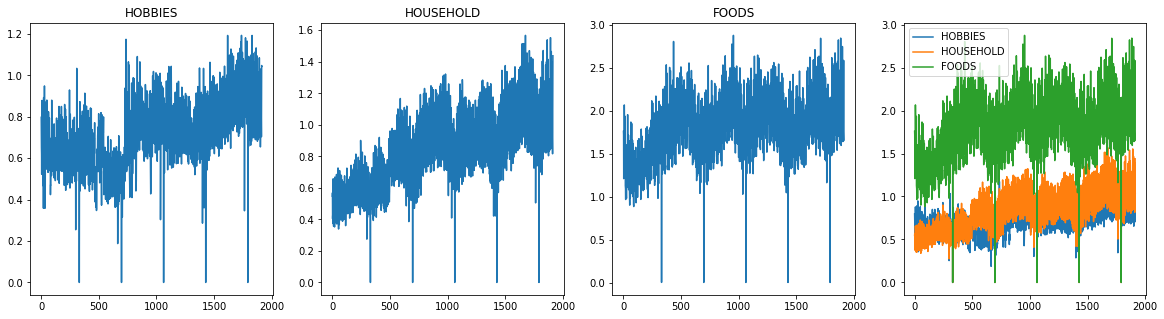

In [0]:
ploting_1(CA_sale)

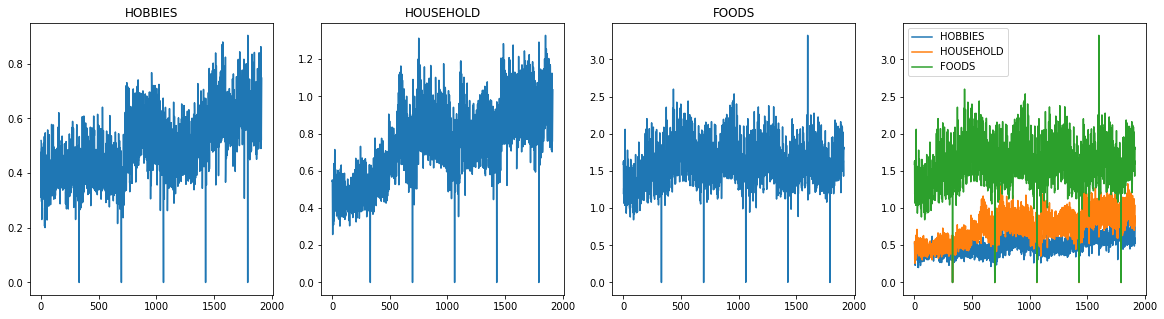

In [0]:
ploting_1(TX_sale)

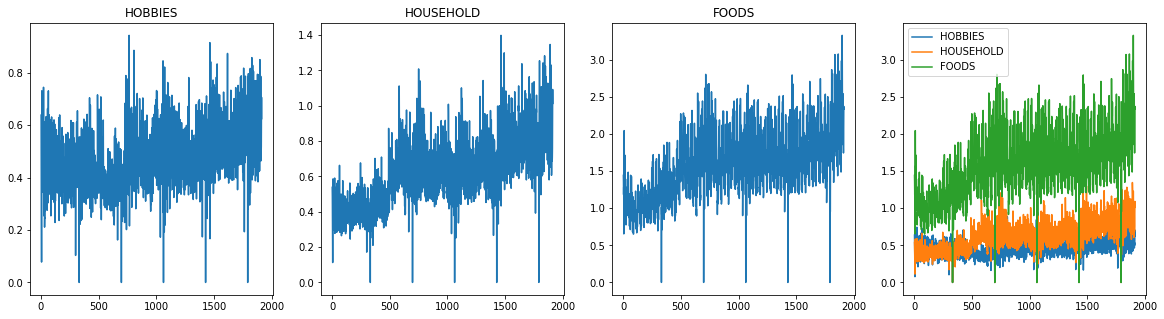

In [0]:
ploting_1(WI_sale)

state 모두, FOODS에 대한 소비량이 다른 품목들에 비해 높게 나옴.
- FOODS > HOUSEHOLD > HOBBIES 순으로 구성

---

## CA

In [0]:
CA_sale.head()

,id,d,value,wm_yr_wk,sell_price,National,Sporting,Cultural,Religious,LentStart,StPatricksDay,Halloween,Eid al-Fitr,LaborDay,Ramadan starts,NBAFinalsStart,SuperBowl,ValentinesDay,LentWeek2,NBAFinalsEnd,Thanksgiving,Cinco De Mayo,EidAlAdha,Christmas,VeteransDay,OrthodoxChristmas,Purim End,Mother's day,MartinLutherKingDay,PresidentsDay,Easter,NewYear,Father's day,IndependenceDay,Chanukah End,Pesach End,ColumbusDay,MemorialDay,OrthodoxEaster,snap_CA,snap_TX,snap_WI,year,month,wday,store,kind
0,HOBBIES_1_001_CA_1,1,0,11101,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2011,1,1,CA_1,HOBBIES
1,HOBBIES_1_002_CA_1,1,0,11101,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2011,1,1,CA_1,HOBBIES
2,HOBBIES_1_003_CA_1,1,0,11101,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2011,1,1,CA_1,HOBBIES
3,HOBBIES_1_004_CA_1,1,0,11101,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2011,1,1,CA_1,HOBBIES
4,HOBBIES_1_005_CA_1,1,0,11101,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2011,1,1,CA_1,HOBBIES


### CA_HOBBIES

In [0]:
CA_HOBBIES=CA_sale[CA_sale['kind'] =='HOBBIES']

In [0]:
CA_HOBBIES.head()

,id,d,value,wm_yr_wk,sell_price,National,Sporting,Cultural,Religious,LentStart,StPatricksDay,Halloween,Eid al-Fitr,LaborDay,Ramadan starts,NBAFinalsStart,SuperBowl,ValentinesDay,LentWeek2,NBAFinalsEnd,Thanksgiving,Cinco De Mayo,EidAlAdha,Christmas,VeteransDay,OrthodoxChristmas,Purim End,Mother's day,MartinLutherKingDay,PresidentsDay,Easter,NewYear,Father's day,IndependenceDay,Chanukah End,Pesach End,ColumbusDay,MemorialDay,OrthodoxEaster,snap_CA,snap_TX,snap_WI,year,month,wday,store,kind
0,HOBBIES_1_001_CA_1,1,0,11101,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2011,1,1,CA_1,HOBBIES
1,HOBBIES_1_002_CA_1,1,0,11101,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2011,1,1,CA_1,HOBBIES
2,HOBBIES_1_003_CA_1,1,0,11101,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2011,1,1,CA_1,HOBBIES
3,HOBBIES_1_004_CA_1,1,0,11101,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2011,1,1,CA_1,HOBBIES
4,HOBBIES_1_005_CA_1,1,0,11101,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2011,1,1,CA_1,HOBBIES


In [0]:
CA_HOBBIES_mean=pd.DataFrame(CA_HOBBIES.groupby(['store','d'])['value'].mean()).reset_index()
CA_HOBBIES_mean.head()

,store,d,value
0,CA_1,1,0.984071
1,CA_1,2,0.881416
2,CA_1,3,0.734513
3,CA_1,4,0.693805
4,CA_1,5,0.474336


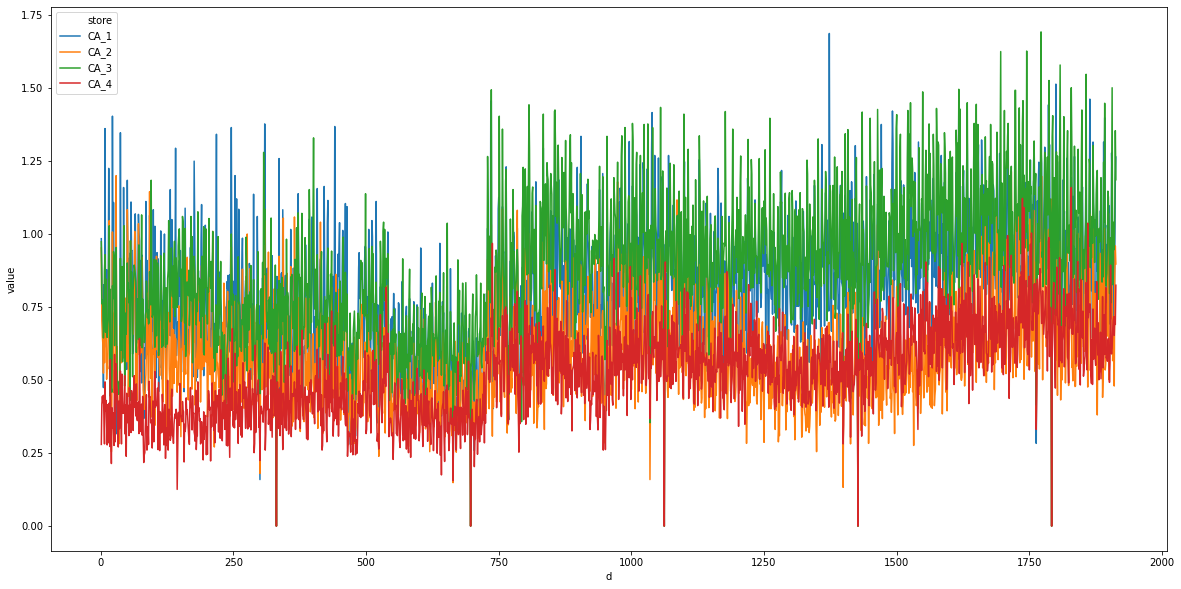

In [0]:
plt.figure(figsize=(20, 10))
sns.lineplot(x='d',y='value',data=CA_HOBBIES_mean,hue='store')

그래프로 봤을 때는 큰 특징을 발견하기 어려워보인다.

In [0]:
CA_festi=CA_HOBBIES_mean.merge(CA_HOBBIES[['d','National','Sporting','Cultural','Religious','store','month','wday','snap_CA']],on=['store','d'],how='left')
CA_festi=CA_festi.drop_duplicates()
CA_festi.head()

,store,d,value,National,Sporting,Cultural,Religious,month,wday,snap_CA
0,CA_1,1,0.984071,0,0,0,0,1,1,0
565,CA_1,2,0.881416,0,0,0,0,1,2,0
1130,CA_1,3,0.734513,0,0,0,0,1,3,0
1695,CA_1,4,0.693805,0,0,0,0,2,4,1
2260,CA_1,5,0.474336,0,0,0,0,2,5,1


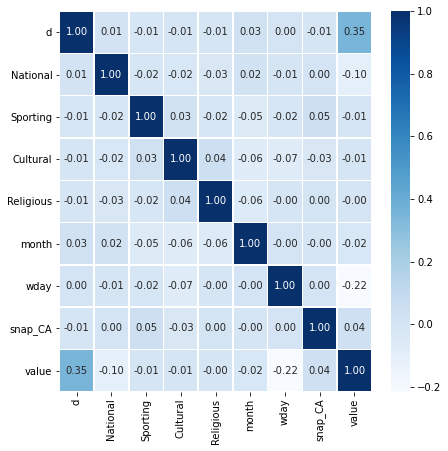

In [0]:
plt.figure(figsize=(7,7))
sns.heatmap(data = CA_festi[['d','National','Sporting','Cultural','Religious','month','wday','snap_CA','value']].corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')

요일의 값이 커질수록 판매량이 줄어드는 것으로 보임.
- 평일보다 주말에 영향을 많이 받는 것으로 보인다. (요일을 원핫 인코딩으로 바꿔 처리해보자)

In [0]:
weekday=pd.get_dummies(CA_festi['wday'])
CA_festi = CA_festi.join(weekday)
CA_festi.head()

,store,d,value,National,Sporting,Cultural,Religious,month,wday,snap_CA,1,2,3,4,5,6,7
0,CA_1,1,0.984071,0,0,0,0,1,1,0,1,0,0,0,0,0,0
565,CA_1,2,0.881416,0,0,0,0,1,2,0,0,1,0,0,0,0,0
1130,CA_1,3,0.734513,0,0,0,0,1,3,0,0,0,1,0,0,0,0
1695,CA_1,4,0.693805,0,0,0,0,2,4,1,0,0,0,1,0,0,0
2260,CA_1,5,0.474336,0,0,0,0,2,5,1,0,0,0,0,1,0,0


In [0]:
CA_festi.drop('wday',axis=1,inplace=True)

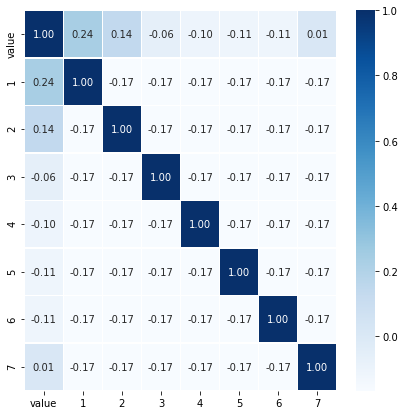

In [0]:
CA_festi[['value',1,2,3,4,5,6,7]]

plt.figure(figsize=(7,7))
sns.heatmap(data = CA_festi[['value',1,2,3,4,5,6,7]].corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')

강하지는 않지만 확실히 평일과 주말에 대한 판매량의 주기성이 띄는 것으로 보인다.